In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import *
from keras.optimizers import Adam
from statistics import mean
import os
from numpy import array
import tensorflow as tf

Using TensorFlow backend.


In [3]:
np.random.seed(7)
gm = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/General Motors 5 years.csv', header=0, index_col=0)
ftse = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/FTSE100.csv', header=0, index_col=0)
dow =  pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/Dow Jones US AUTO STOCK INDEX-5 Years.csv', header=0, index_col=0)

In [4]:
def normalize(data):
    
    scaler_open = MinMaxScaler()
    scaler_high = MinMaxScaler()
    scaler_low = MinMaxScaler()
    scaler_close = MinMaxScaler()
    scaler_adjclose = MinMaxScaler()
    scaler_volume = MinMaxScaler()
    
    #Open:
    fit = scaler_open.fit(np.array(data['Open']).reshape(-1, 1))
    data['Open'] =scaler_open.transform(np.array(data['Open']).reshape(-1, 1))
    
    #High:
    fit = scaler_high.fit(np.array(data['High']).reshape(-1, 1))
    data['High'] =scaler_high.transform(np.array(data['High']).reshape(-1, 1))
    
    #Low:
    fit = scaler_low.fit(np.array(data['Low']).reshape(-1, 1))
    data['Low'] =scaler_low.transform(np.array(data['Low']).reshape(-1, 1))
    
    #Close:
    fit = scaler_close.fit(np.array(data['Close']).reshape(-1, 1))
    data['Close'] =scaler_close.transform(np.array(data['Close']).reshape(-1, 1))
    
    #AdjClose:
    fit = scaler_adjclose.fit(np.array(data['Adj Close']).reshape(-1, 1))
    data['Adj Close'] =scaler_adjclose.transform(np.array(data['Adj Close']).reshape(-1, 1))
    
    #High:
    fit = scaler_volume.fit(np.array(data['Volume']).reshape(-1, 1))
    data['Volume'] =scaler_volume.transform(np.array(data['Volume']).reshape(-1, 1))
    
    return data,scaler_high

df = gm
dataframe_gm = df
df,scaler = normalize(df)

#convert data: form X and y data:
Xarr = df.rename_axis('ID').values
Xarr = Xarr[0:1258]
Datearr = df.index.values

df1 = df[['High']]
yarr = df1.rename_axis('ID').values
yarr = np.delete(yarr, 0)

Xarr = Xarr.reshape((Xarr.shape[0], Xarr.shape[1], 1))

df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-05-15,0.620900,0.582270,0.648933,0.610175,0.440398,0.120612
2015-05-18,0.630030,0.590426,0.653711,0.614892,0.444842,0.129499
2015-05-19,0.636794,0.591489,0.657216,0.617251,0.447065,0.121978
2015-05-20,0.639161,0.593617,0.647658,0.613881,0.443890,0.175782
2015-05-21,0.631045,0.606383,0.658490,0.632749,0.461669,0.229963
...,...,...,...,...,...,...
2020-05-08,0.227596,0.192908,0.277795,0.240229,0.283463,0.239541
2020-05-11,0.233683,0.171277,0.263141,0.202156,0.238539,0.242902
2020-05-12,0.224890,0.167021,0.261867,0.194070,0.228997,0.162761


In [5]:
def build_data(start,pw,window_size=200):
    
    X_train,X_test = Xarr[start:start+window_size],Xarr[start+window_size:start+window_size+pw]
    y_train,y_test = yarr[start:start+window_size],yarr[start+window_size:start+window_size+pw]
    Date_train,Date_test = Datearr[start:start+window_size],Datearr[start+window_size:start+window_size+pw]
    return X_train,X_test,y_train,y_test,Date_train,Date_test

trn_size = len(Xarr)
X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(0,pw=1,window_size = 200)
print(X_train.shape)


(200, 6, 1)


# 1. General Motors - LSTM:

In [5]:
file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
    
callbacks = [early_stopping, callback_checkpoint]
adam = Adam(lr=0.003)
model = Sequential()
model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(16))
model.add(Dense(1))
model.compile(loss="mean_absolute_error", optimizer=adam)

In [6]:
#window size =1:
import time
from itertools import chain
start_time = time.time()


val_loss = []
window = 200

for sample in range(0,5):
    print('starting sample:',sample,'...')
    predicted_high = []
    actual_high = []
    predicted_dates = []
    model_loss = []
    model_val_loss =[]

    for trn in range(0,trn_size-window):
        X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=1,window_size = window)
        #print(trn)
    
        history = model.fit(X_train, y_train,verbose = 0, epochs=100,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
        yhat = model.predict(X_test, verbose=0)
    
        predicted_high.append(yhat[0])
        predicted_dates.append(Date_test[0])
        actual_high.append(y_test[0])
        model_loss.append(history.history['loss'][-1])
        model_val_loss.append(history.history['val_loss'][-1])
    print('completed sample:',sample,'...')
    val_loss.append(round(mean(model_val_loss),8))
    
time_taken = time.time() - start_time
print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(val_loss),8)) 
    

starting sample: 0 ...
completed sample: 0 ...
starting sample: 1 ...
completed sample: 1 ...
starting sample: 2 ...
completed sample: 2 ...
starting sample: 3 ...
completed sample: 3 ...
starting sample: 4 ...
completed sample: 4 ...
time taken for execution : 16406.376497983932 seconds 
Mean Validation loss= 0.02237747


starting sample: 0 ...
completed sample: 0 ...
time taken for execution : 528.7853560447693 seconds 
Mean Validation loss= 0.02322307


<BarContainer object of 101 artists>

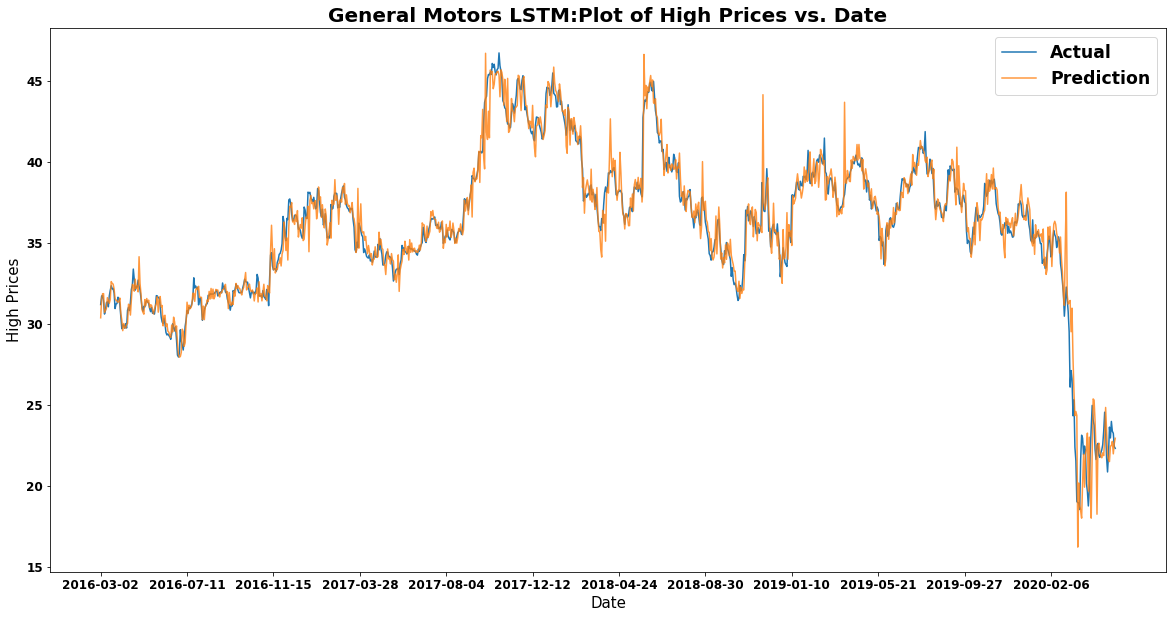

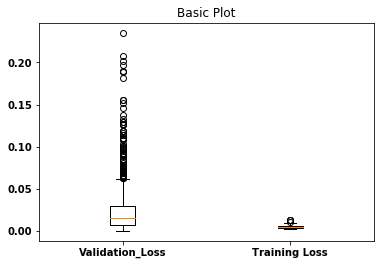

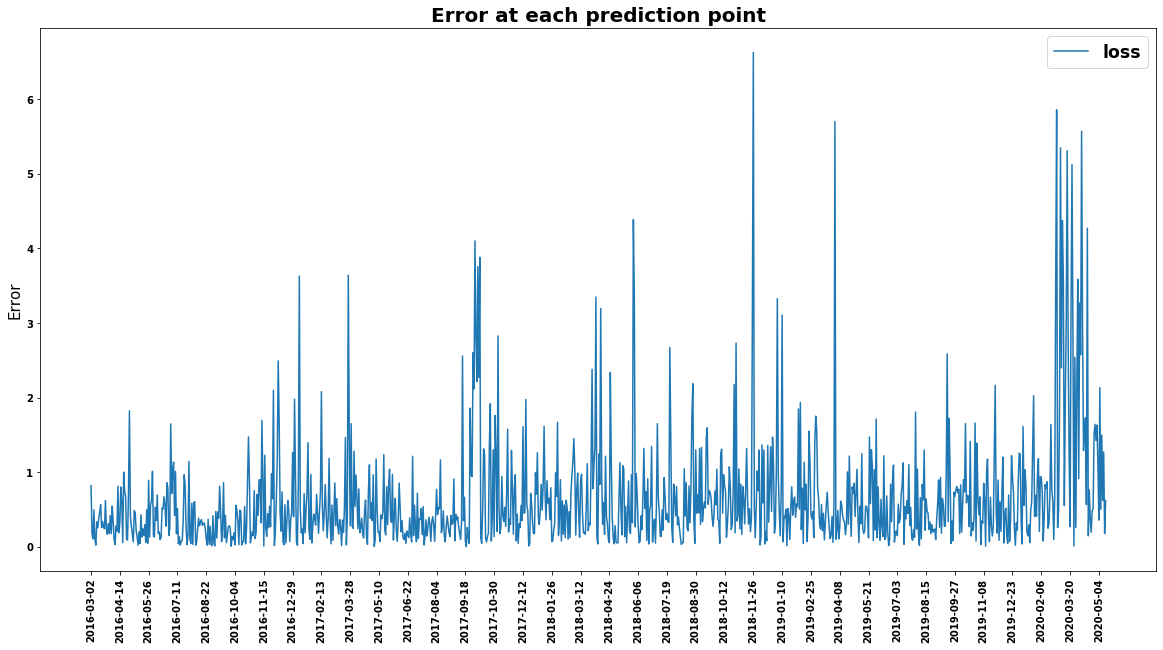

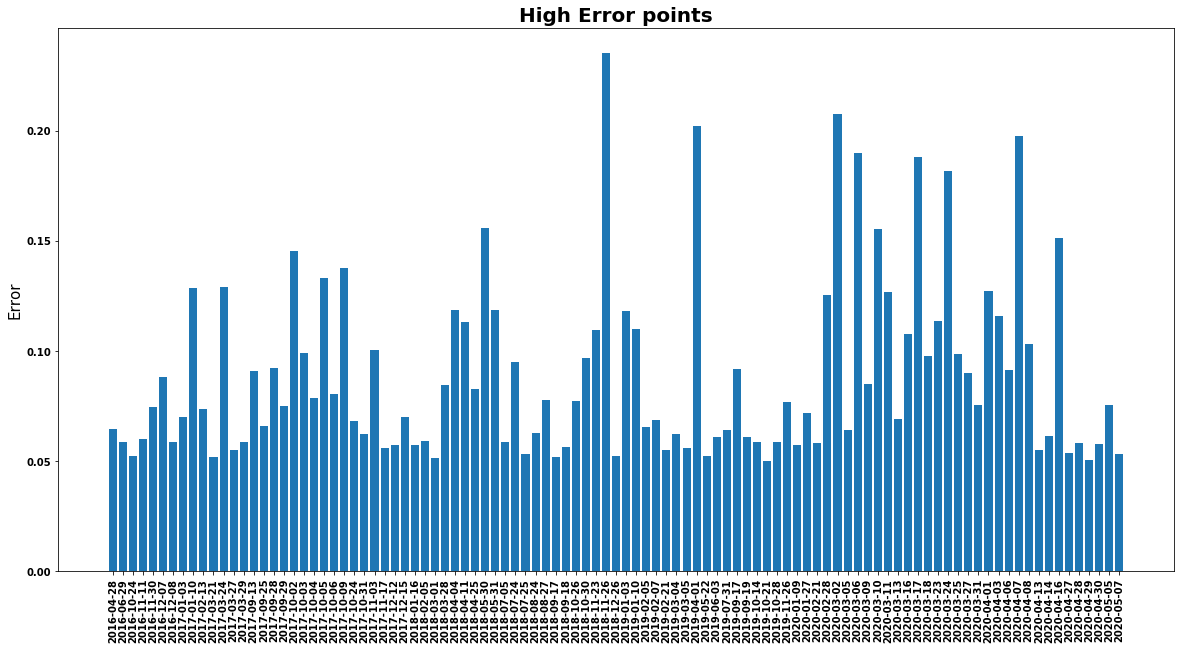

In [9]:
import time
from itertools import chain
start_time = time.time()

window = 200
val_loss = []

for sample in range(0,1):
    print('starting sample:',sample,'...')
    predicted_high = []
    actual_high = []
    predicted_dates = []
    model_loss = []
    model_val_loss =[]
    for trn in range(0,trn_size-window):
        X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=1,window_size = window)
    
        history = model.fit(X_train, y_train,verbose = 0, epochs=200,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
        yhat = model.predict(X_test, verbose=0)
        yhat = list(chain.from_iterable(yhat)) 
        if len(predicted_high) == 0:
            predicted_high = yhat
            predicted_dates = Date_test.tolist()
            actual_high = y_test.tolist()
            model_loss.append(history.history['loss'][-1])
            model_val_loss.append(history.history['val_loss'][-1])
        
        
        else:
            beg=len(predicted_high)-len(yhat)+1
            yhat_idx = 0
            for pred_idx in range(beg,len(predicted_high)):
                predicted_high[pred_idx]= (predicted_high[pred_idx] + yhat[yhat_idx])/2
                yhat_idx+=1
            predicted_high.append(yhat[-1])
            actual_high.append(y_test[-1])
            predicted_dates.append(Date_test.tolist()[-1])
            model_loss.append(history.history['loss'][-1])
            model_val_loss.append(history.history['val_loss'][-1])
    
    print('completed sample:',sample,'...')
    val_loss.append(round(mean(model_val_loss),8))
    
time_taken = time.time() - start_time
print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(val_loss),8)) 

        
def evaluate_model(y_predicted,y_actual,dates):

    plt.figure(figsize=(20,10))
    plt.title('General Motors LSTM:Plot of High Prices vs. Date',fontsize=20,fontweight='bold')
    plt.xlabel('Date',fontsize=15)
    plt.ylabel('High Prices',fontsize=15)
    plt.plot((y_actual.reshape(-1,1)), label="Actual")#,color='red')
    plt.plot(y_predicted.reshape(-1,1), label="Prediction", alpha=0.8)#,color ='black')
    index = np.arange((len(y_predicted)-1),step=90)
    plt.xticks(index,dates[index],fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize="xx-large")
    
    fig1, ax1 = plt.subplots()
    ax1.set_title('Basic Plot')
    data = [model_val_loss,model_loss]
    ax1.boxplot(data,labels = ['Validation_Loss','Training Loss'])

 
#Rescaling the high values from range 0-1 to original values:
actual= scaler.inverse_transform(np.array(actual_high).reshape(-1,1))
predicted = scaler.inverse_transform(np.array(predicted_high).reshape(-1,1))
evaluate_model(predicted,actual,np.array(predicted_dates))

def mae(y_predicted,y_actual,dates):
    n = len(y_predicted)
    loss = []
    for i in range(0,n):
        loss.append(abs(y_predicted[i] - y_actual[i]))
    index = np.arange((len(loss)),step=30)
    
    plt.figure(figsize=(20,10))
    plt.title('Error at each prediction point',fontsize=20,fontweight='bold')
    plt.ylabel('Error',fontsize=15)
    plt.xticks(index,dates[index],rotation=90)
    plt.plot((np.array(loss).reshape(-1,1)), label="loss")
    plt.legend(fontsize="xx-large")

mae(predicted,actual,np.array(predicted_dates))

large_loss = []
large_loss_date = []
for index in range(0,len(model_val_loss)):
    val_loss = model_val_loss[index]
    if val_loss>0.05:
        #print(f'{index:5} {val_loss:12f} {predicted_dates[index]:20} {predicted[index][0]:10f} {actual[index][0]:15f}')
        large_loss.append(val_loss)
        large_loss_date.append(predicted_dates[index])


plt.rcParams["font.weight"] = "bold"
plt.figure(figsize=(20,10))
plt.title('High Error points',fontsize=20,fontweight='bold')
plt.ylabel('Error',fontsize=15)
idx = np.arange(len(large_loss_date))
plt.xticks(idx,large_loss_date,rotation=90)
plt.bar(idx, large_loss, align='center', alpha=1)
